# Forward model for M/EEG source analysis

This notebook illustrates how to use features of the `stormdb.process`-module to process anatomical MR information in order to produce:

* extraction of cortical sheet (_Freesurfer_ `recon-all`)
    * gray- and white-matter boundaries
* creation of tissue surface layers for the purpose of Boundary Element Model (BEM) based forward models

_All computations are performed on the `hyades`-cluster._

## Alternate pathways for BEM surface creation

There are three distinct paths that can be taken:

1. [watershed] You only have a high-resolution (ca. 1 mm cubic voxels) T1-weighted image
    * only an estimate of the inner skull boundary can be obtained
1. [flash] In addition to the T1, you have a multi-echo FLASH sequence (proton density-like contrast); generates inner- and outer-skull & skin
    * a 5-degree flip angle image is compulsory
    * the optional 30-degree image does not appear to improve surface quality
    * the 5-degree image can have as few as 5 echos
1. [simnibs] You have 2 or 4 images, and use the [SimNIBS](http://www.simnibs.de) `mri2mesh`-pipeline to generate surfaces (_recommended as of 2016_); generates inner- and outer-skull & skin
    * a T1 with fat saturation (_compulsory_)
    * a T2 with high bandwidth (_compulsory_)
    * a T1 with high bandwidth (_optional_)
    * a T2 with fat saturation (_optional_)
   

## Step 1: Cortex extraction

All pathways are based on the `recon-all` analysis stream of [Freesurfer](http://www.freesurfer.net). __NB__: SimNIBS calls `recon-all` with a bunch of tweaks---you should let `mri2mesh` take care of these for you. For watershed and flash, you should call `recon-all` explicitly.

### Using Freesurfer / `recon-all`

In [ ]:
import os.path as op
from stormdb.process import Freesurfer
from stormdb.base import mkdir_p  # mkdir -p

In [ ]:
proj_name = 'MINDLAB2015_MEG-Sememene'
subject = '0010_HXN'  # full code must be given!
subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')
mkdir_p(subjects_dir)  # this must exist
t1_name = '*t1_mpr*'  # 3D_T1_SAG_t1_mpr_sag_p2_iso_FCread_Tardif

First prepare a `recon-all`-command:

In [ ]:
fs = Freesurfer(proj_name=proj_name, subjects_dir=subjects_dir)
fs.recon_all?

Since `recon-all` takes 6-10 hours, you should use the `long.q`! (default)

__NB__: Due to some issues with how `Freesurfer` does DICOM-conversion, the command below will spend about 15 seconds (per subject) converting the data. All other processing steps will be performed on the cluster, after calling `submit()`.

In [ ]:
fs.recon_all(subject, t1_series=t1_name)

In [ ]:
fs.submit(fake=True)

In [ ]:
fs.submit()

In [ ]:
fs.status

### Using SimNIBS / `mri2mesh`

See SimNIBS documentation for details!

__NB__: The parameter `output_dir` determines where `mri2mesh` writes its outputs in the form:

* `m2m_{subject A name}`
* `fs_{subject A name}`

Because `MNE` and `mne-python` require a `subjects_dir`-folder with the structure

* `{subject A name}`
* `{subject B name}`
* ...

we will pass `link_to_subjects_dir` to `mri2mesh` in order to create symbolic links between the two folder.

In [ ]:
import os.path as op
from stormdb.process import SimNIBS
from stormdb.base import mkdir_p  # mkdir -p

In [ ]:
proj_name = 'MINDLAB2016_MEG-Language-PD-DBS'
subject = '0008_CCP'  # full code must be given!
output_dir = op.join('/projects', proj_name, 'scratch', 'sn_subjects_dir')
subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')
mkdir_p(subjects_dir)  # this must exist
mkdir_p(output_dir)  # this must exist
t1_fs = 't1_*_fatsat'  # t1_mprage_3D_sag_fatsat
t2_hb = 't2_*_HighBW'  # t2_tse_sag_HighBW

First prepare a `mri2mesh`-command:

In [ ]:
sn = SimNIBS(proj_name=proj_name, output_dir=output_dir)
sn.mri2mesh?

Since `mri2mesh` takes 6-10 hours, you should use the `long.q`! (default)

__NB__: Due to some issues with how `Freesurfer` does DICOM-conversion, the command below will spend about 15 seconds (per image) converting the data. All other processing steps will be performed on the cluster, after calling `submit()`.

In [ ]:
sn.mri2mesh(subject, t1_fs=t1_fs, t2_hb=t2_hb, t2mask=True,
            link_to_fs_dir=subjects_dir)

In [ ]:
sn.submit(fake=True)

In [ ]:
sn.submit()

In [ ]:
sn.status

## Step 2: Wait!

The following stages are only possible after the surface reconstruction(s) above are completed. You may shut down the current python kernel and return tomorrow. To checkt the status of your jobs on the queue, open up a terminal and type

```bash
qstat
```

The standard output stream of the jobs submitted are by default written to the same directory as the present notebook.

## Step 3: Create BEM surfaces

__NB__: All of the following pathways create a high-density skin surface image for MEG-MRI coregistration purposes (according to the standard MNE-pipeline); the flag `make_coreg_head`-parameter of `create_bem_surfaces` is set to `True` by default.

### Watershed

In [ ]:
import os.path as op
from stormdb.process import Freesurfer

In [ ]:
proj_name = 'MINDLAB2015_MEG-Sememene'
subject = '0010_HXN'  # full code must be given!
subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')

In [ ]:
fs_ws = Freesurfer(proj_name=proj_name, subjects_dir=subjects_dir)
fs_ws.create_bem_surfaces?

In [ ]:
fs_ws.create_bem_surfaces(subject, make_coreg_head=False)

In [ ]:
fs_ws.submit(fake=True)

In [ ]:
fs_ws.submit()

In [ ]:
fs_ws.status

### Multi-echo FLASH

The example below is for a 5-degree flip angle image ("`flash5`") with 5 echos (instead of the usual 8).

In [ ]:
import os.path as op
from stormdb.process import Freesurfer

In [ ]:
proj_name = 'MINDLAB2015_MEG-Sememene'
subject = '0010_HXN'  # full code must be given!
subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')
flash5_name = '*gre_5*'  # gre_5_PDW_5echo_sag, the code handles the 5<8 echos automatically

In [ ]:
fs_flash = Freesurfer(proj_name=proj_name, subjects_dir=subjects_dir)
fs_flash.create_bem_surfaces?

In [ ]:
fs_flash.create_bem_surfaces(subject, flash5=flash5_name, make_coreg_head=False)

In [ ]:
fs_flash.submit(fake=True)

In [ ]:
fs_flash.submit()

In [ ]:
fs_flash.status

### SimNIBS surface extraction

In [ ]:
import os.path as op
from stormdb.process import SimNIBS

In [ ]:
proj_name = 'MINDLAB2016_MEG-Language-PD-DBS'
subject = '0008_CCP'  # full code must be given!
output_dir = op.join('/projects', proj_name, 'scratch', 'sn_subjects_dir')
subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')

In [ ]:
sn_bem = SimNIBS(proj_name=proj_name, output_dir=output_dir)
sn_bem.create_bem_surfaces?

In [ ]:
sn_bem.create_bem_surfaces(subject, make_coreg_head=False)

In [ ]:
sn_bem.submit()

In [ ]:
sn_bem.status

# Visualise the BEM surfaces

Done here for the final example using `SimNIBS`-based surfaces. Uncomment the following cell to show watershed- or flash-based surfaces.

In [ ]:
# proj_name = 'MINDLAB2015_MEG-Sememene'
# subject = '0010_HXN'  # full code must be given!
# subjects_dir = op.join('/projects', proj_name, 'scratch', 'fs_subjects_dir')

In [11]:
%matplotlib notebook

In [12]:
from mne.viz import plot_bem

Using surface: /projects/MINDLAB2016_MEG-Language-PD-DBS/scratch/fs_subjects_dir/0008_CCP/bem/inner_skull.surf
Using surface: /projects/MINDLAB2016_MEG-Language-PD-DBS/scratch/fs_subjects_dir/0008_CCP/bem/outer_skull.surf
Using surface: /projects/MINDLAB2016_MEG-Language-PD-DBS/scratch/fs_subjects_dir/0008_CCP/bem/outer_skin.surf
Triangle file: created by cjb on Fri Feb  3 18:30:05 2017 nvert = 5120 ntri = 10236
Triangle file: created by cjb on Fri Feb  3 18:29:30 2017 nvert = 5120 ntri = 10236
Triangle file: created by cjb on Fri Feb  3 18:29:40 2017 nvert = 5120 ntri = 10252
Triangle file: created by cjb on Fri Feb  3 05:06:46 2017 nvert = 163504 ntri = 327004
Triangle file: created by cjb on Fri Feb  3 05:27:35 2017 nvert = 164886 ntri = 329768


<IPython.core.display.Javascript object>


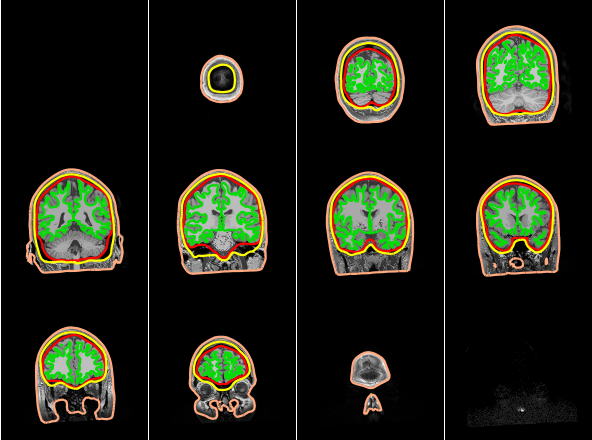

In [13]:
_ = plot_bem(subject=subject, subjects_dir=subjects_dir,
             brain_surfaces='white', orientation='coronal')